## Reinforcement learning: Problem Set 2- Approximate Dynamic Programming

In [14]:
# Initial set up
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import seaborn as sns

First of all I am going to define the elements of the MDP: action set, state set and transition function.

In the cells below, I define two matrices containing the probability of occurrence for each possible state. I build one matrix for action = low and one for action = high.

In both matrices there are two special cases in which the probabilities are different in comparison to the other values:  transition from $x_t = 0$ to $x_{t+1}=-1$ and from $x_t = 99$ to $x_{t+1}=100$. The queue length is updated following a "trunc" operator that truncates the interval to $[0, N-1]$, so probabilities in the upper left and lower right corners change. For example, it is impossible to be in state  $x_t = 0$ and take any action that decreases the queue in one person. Then, in both cases I incremented the probability in the diagonal I.e. not changing state. 

In [39]:
# Properties of the MDP
N = 100 # Number of states
q_low = 0.51 #probability of action_low
q_high = 0.6 #probability of action_high
c_low = 0 #cost of action low
c_high = 0.01 #cost of action high
p = 0.5 #arrival rate
gamma=0.9 # discount factor

In [40]:
# Action high

m_high = np.zeros(shape=(N,N))
np.fill_diagonal(m_high,(p*q_high)+(1-p)*(1-q_high))

# right
for i in range(N-1):
    if i != N-1:
        m_high[i][i+1]=p*(1-q_high)
    if i == 0:
        m_high[i][i+1]=0.2
        m_high[i][i]=0.8

# Left
for i in range(N):
    if i != 0:
        m_high[i][i-1]=(1-p)*(q_high)
    if i == N-1:
        m_high[i][i-1]=0.3
        m_high[i][i]=0.7

print(m_high)


[[0.8 0.2 0.  ... 0.  0.  0. ]
 [0.3 0.5 0.2 ... 0.  0.  0. ]
 [0.  0.3 0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.5 0.2 0. ]
 [0.  0.  0.  ... 0.3 0.5 0.2]
 [0.  0.  0.  ... 0.  0.3 0.7]]


In [41]:
# Action low         
m_low = np.zeros(shape=(N,N))
np.fill_diagonal(m_low,(p*q_low)+(1-p)*(1-q_low))

# right
for i in range(N-1):
    if i != N-1:
        m_low[i][i+1]=p*(1-q_low)
    if i == 0:
        m_low[i][i+1]=0.245
        m_low[i][i]=0.755
# Left
for i in range(N):
    if i != 0:
        m_low[i][i-1]=(1-p)*(q_low)
    if i ==N-1:
        m_low[i][i-1]=0.255
        m_low[i][i]=0.745
print(m_low)

[[0.755 0.245 0.    ... 0.    0.    0.   ]
 [0.255 0.5   0.245 ... 0.    0.    0.   ]
 [0.    0.255 0.5   ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.5   0.245 0.   ]
 [0.    0.    0.    ... 0.255 0.5   0.245]
 [0.    0.    0.    ... 0.    0.255 0.745]]


In [42]:
# Reward function
def reward (q,x):    
    if q == q_low:
        r = -(x/N)**2 -c_low
    if  q == q_high:
        r = -(x/N)**2 -c_high   
    return r


In the three cells bellow I define the functions of each feature map: Fine, Coarse and Piecewise

In [43]:
# Fine feature map:
def fine_feature (N,x):
    return np.eye(N)[x]


In [44]:
# Coarse feature map
def coarse_feature(N,x):
    final_vector = []
    for i in range(1,int(N/5)+1):
        lower_bound = 5*(i-1)
        upper_bound =5*i-1
        if lower_bound <= x <= upper_bound:
            final_vector.append(1)
        else:
            final_vector.append(0)
    return np.array(final_vector)  

In [45]:
# Piecewise linear feature
def piecewise_feature(N,x):
    v1 = coarse_feature(N,x)
    v2 = coarse_feature(N,x)
    v3 = []
    for i in range(1,int(N/5)+1):
        v3.append((x-5*(i-1))/5)
    final_vector=np.multiply(v3,v2)
    return np.append(v1,final_vector)   

In [46]:
# Utilities

def feature_maps(maps,N,x):
    if maps == "fine":
        phi = fine_feature (N,x)
    elif maps == 'coarse':
        phi = coarse_feature(N,x)
    elif maps == 'piece':
        phi = piecewise_feature(N,x)
    return phi

def theta_vector(maps,N):
    if maps == "fine":
        theta = np.zeros(N) 
    elif maps == "coarse":
        theta = np.zeros(int(N/5))
    elif maps == "piece":
        theta = np.zeros(2*int(N/5))
    return theta  


def translate_policy(policy):
    return ['lazy' if i[0]==1 else 'aggressive' for i in policy]

def reverse_policy(policy):
    return[0 if i=='lazy' else 1 for i in policy]

#### Temporal Diference

In [47]:
# TD(0)
def TD(N,max_iter,initial_state,maps,a,b,gamma,policy,m_low,m_high,q_low,q_high):
    
    value = np.zeros(N)

    s = initial_state

    theta = theta_vector(maps,N)
    # Define matrix by policy
    if policy == 'lazy':
        matrix = m_low
    elif policy == 'aggressive':
        matrix = np.vstack([m_low[0:50,:],m_high[50:N,:]])
    
    # Iteration
    for t in range(max_iter):
        # reward vector
        reward_vector = []
        if policy == 'lazy':
            q=q_low
            
            for x in range(0,N):
                reward_vector.append(reward(q,x))
        
        elif policy == 'aggressive':
            
            for x in range(0,N):
                
                if x < 50:
                    q=q_low
                else:
                    q=q_high
                reward_vector.append(reward(q,x))

        alpha = a/(t+b)
        s_pr = np.random.choice(list(range(0,100)), p=list(matrix[s]))
        delta = reward_vector[s] + (gamma *np.dot(theta, feature_maps(maps,N,s_pr)))-np.dot(theta,feature_maps(maps,N,s))

        theta = theta +(alpha*delta*feature_maps(maps,N,s))
        s = s_pr

    for j in range (N):
        value[j] = np.dot(theta, feature_maps(maps,N,j))

    return value  

#### Least Squares Temporla Diference

In [52]:
# LSTD (0)

def LSTD(N,max_iter,initial_state,maps,gamma,policy,policy_vector:None,m_low,m_high,q_low,q_high):
    value_vector = np.zeros(N)
    value = np.zeros(N)
    s = initial_state

    theta = theta_vector(maps,N)
    # Define matrix by policy
    if policy == 'lazy':
        matrix = m_low
    elif policy == 'aggressive':
        matrix = np.vstack([m_low[0:50,:],m_high[50:N,:]])
    
    elif policy =='optimal':
        matrix = np.zeros((N,N))
        for pi,ni in zip(policy_vector,list(range(N))):
            if pi == 'lazy':
                row = m_low[ni,:]
            elif pi == 'aggressive':
                row = m_high[ni,:]
            matrix[ni,:] = row


    A_B_matrix = 0
    b = 0

    # Iteration
    for t in range(max_iter):
        # reward vector
        reward_vector = []
        if policy == 'lazy':
            q=q_low
            
            for x in range(0,N):
                reward_vector.append(reward(q,x))
        elif policy == 'aggressive':
            
            for x in range(0,N):
                
                if x < 50:
                    q=q_low
                else:
                    q=q_high
                reward_vector.append(reward(q,x))
        elif policy =='optimal':
            for pi,ni in zip(policy_vector,list(range(N))):
                if pi == 'lazy':
                    q=q_low
                elif pi == 'aggressive':
                    q=q_high
                reward_vector.append(reward(q,ni))
        
        s_pr = np.random.choice(list(range(0,100)), p=list(matrix[s]))
        mapping_x = np.matrix(feature_maps(maps,N,s))
        mapping_next = np.matrix(feature_maps(maps,N,s_pr))
        
        A_B_matrix += mapping_x.T*(mapping_x - gamma*mapping_next)
        b +=reward_vector[s]*mapping_x

        s = s_pr

    A_B_matrix = np.linalg.pinv(A_B_matrix)
    theta = b*A_B_matrix    

    
    for j in range (N):
        value[j] = np.dot(theta, feature_maps(maps,N,j))
        
    return value  

### Problem 1: Approximate policy evaluation

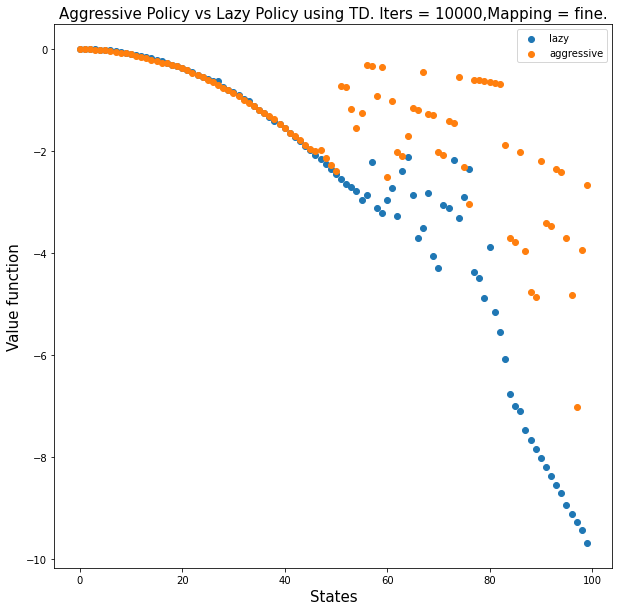

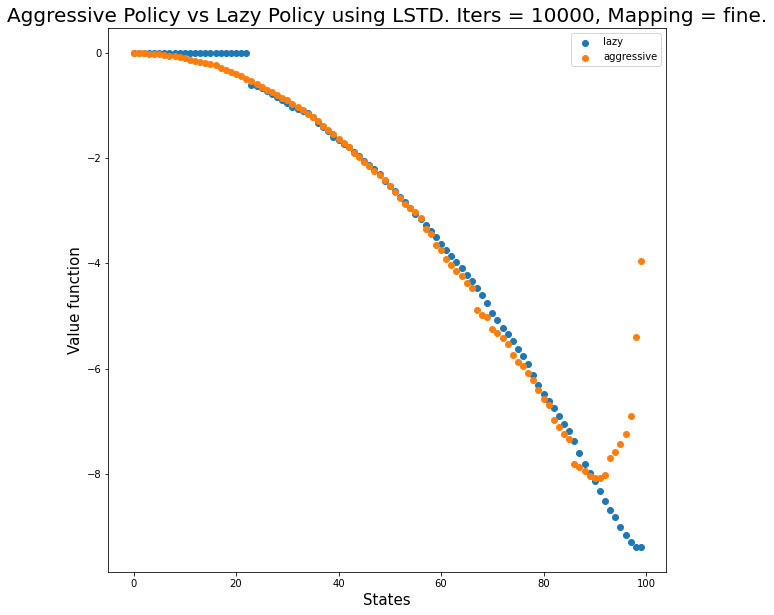

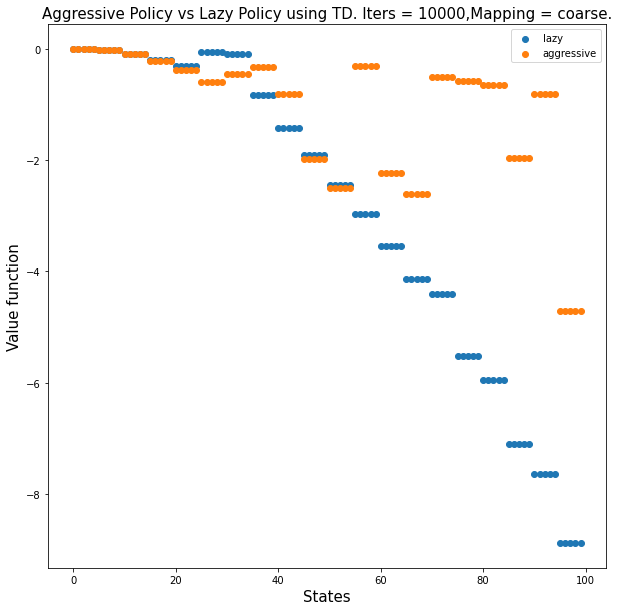

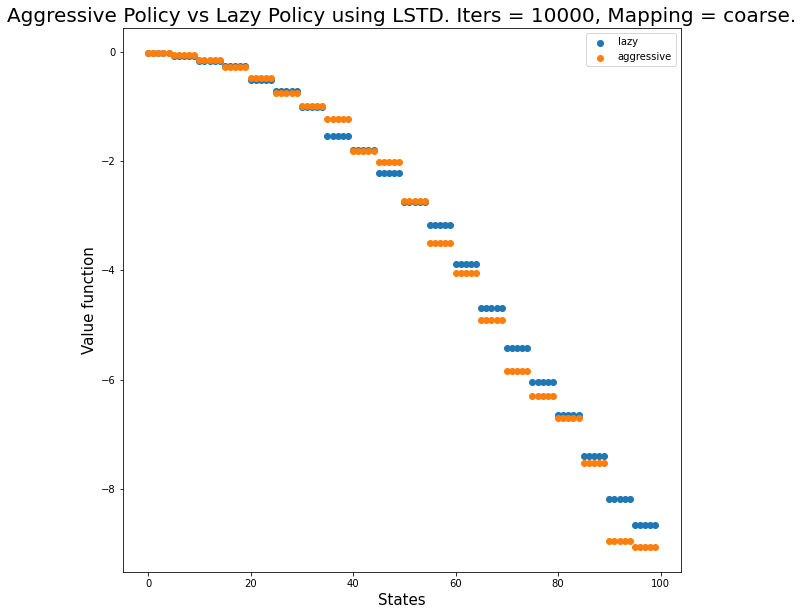

Doing well !!


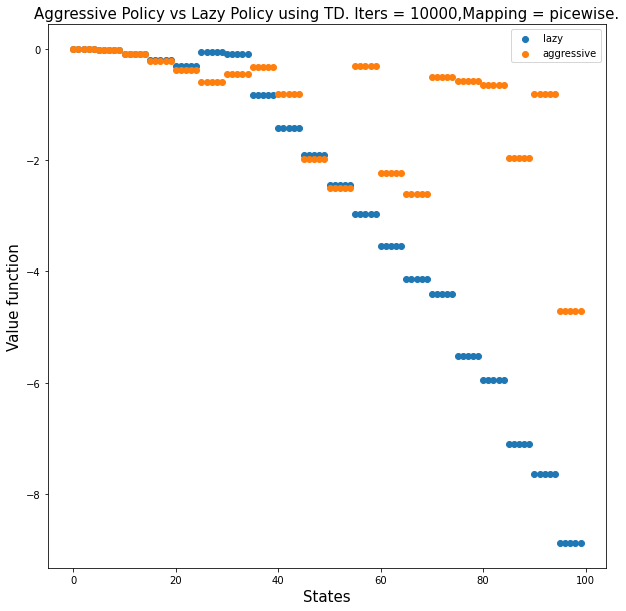

Looking good


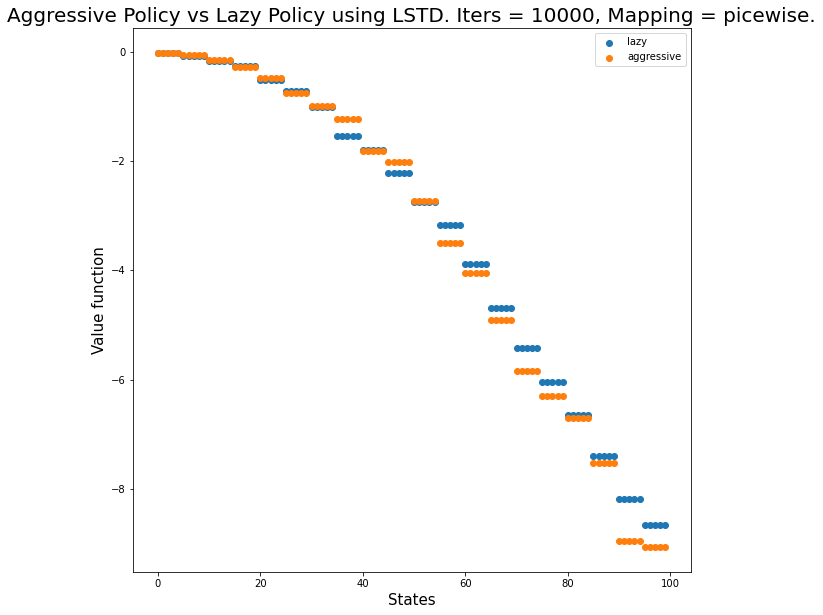

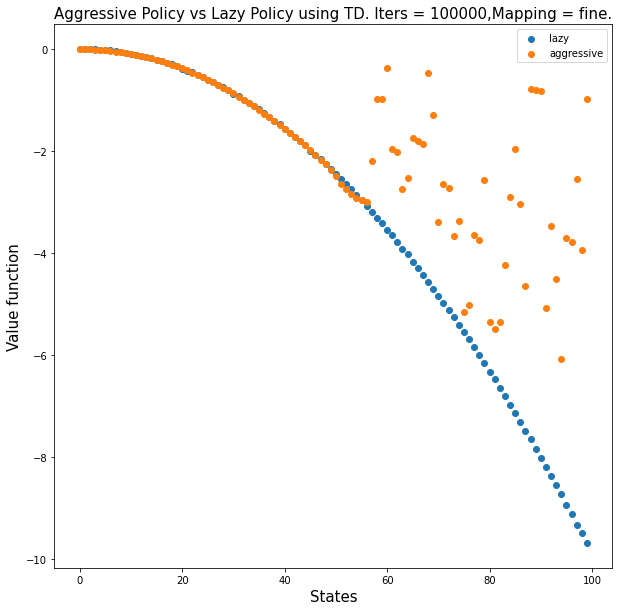

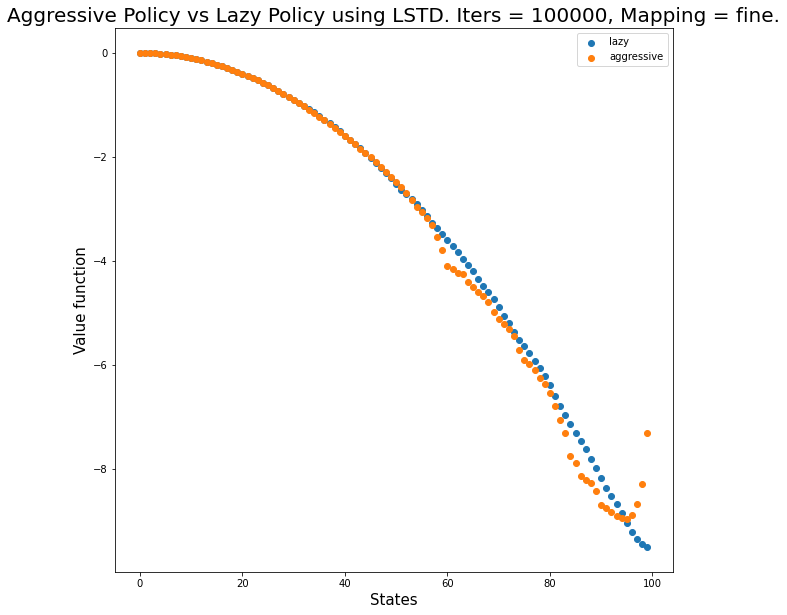

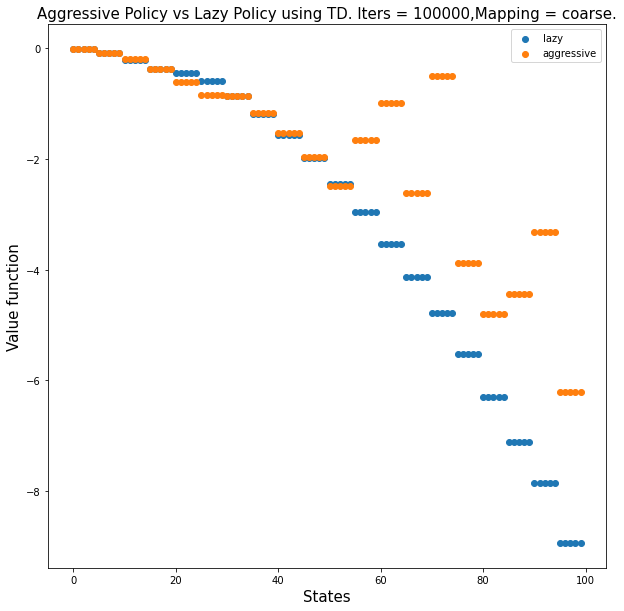

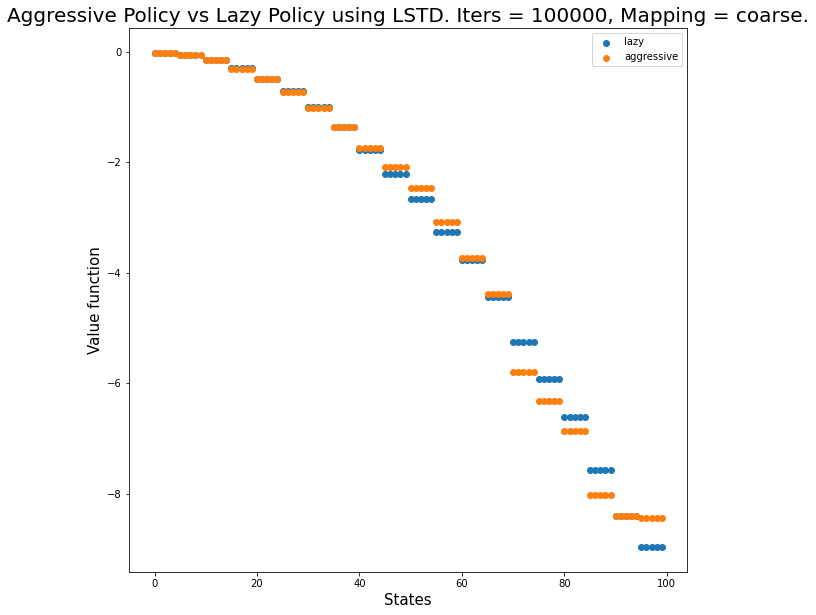

Doing well !!


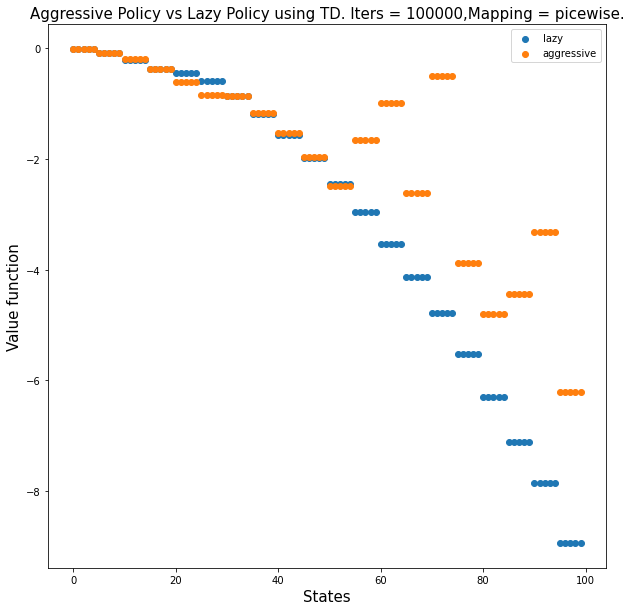

Looking good


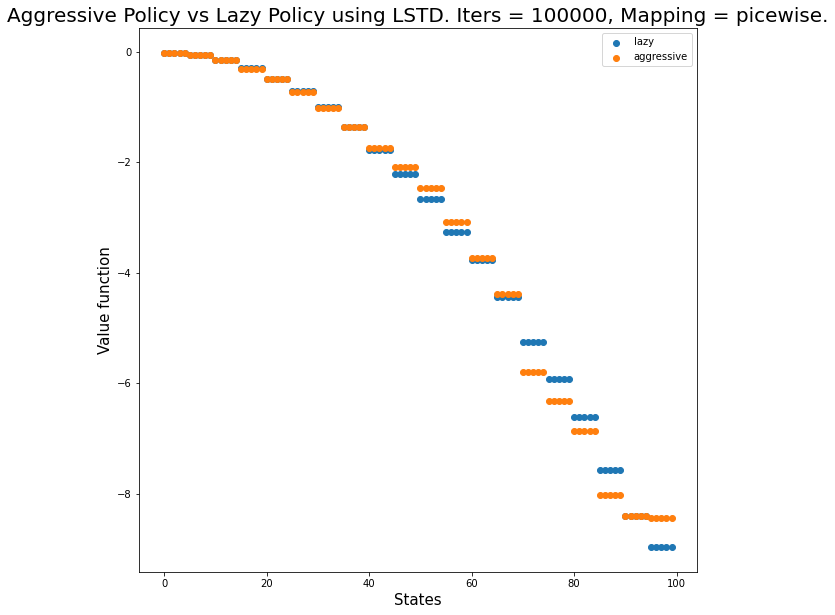

In [53]:
# Plot
for iters in [10000,100000]:
    for mapping in ['fine','coarse','picewise']:
        try:
            value_lazy = TD(N=100,max_iter=iters,initial_state=99,maps=mapping,a=1000000,b=1000000,policy='lazy',gamma=0.9,m_low=m_low,m_high=m_high,q_low=q_low,q_high=q_high)
            value_aggre = TD(N=100,max_iter=iters,initial_state=99,maps=mapping,a=1000000,b=1000000,policy='aggressive',gamma=0.9,m_low=m_low,m_high=m_high,q_low=q_low,q_high=q_high)
        except:

            print('Doing well !!')
        plt.figure(figsize=(10,10))
        plt.xlabel('States', fontsize='15')
        plt.ylabel('Value function',fontsize='15')
        plt.title(f'Aggressive Policy vs Lazy Policy using TD. Iters = {iters},Mapping = {mapping}.',fontsize='15')
        plt.scatter(list(range(100)), y = value_lazy, label="lazy")
        plt.scatter(list(range(100)), y = value_aggre, label="aggressive")

        plt.legend()
        plt.show()
        
        try:
            value_lazy_lstd = LSTD(N=100,max_iter=iters,initial_state=99,maps=mapping,policy='lazy',gamma=0.9,m_low=m_low,m_high=m_high,q_low=q_low,q_high=q_high,policy_vector=None)
            value_aggre_lstd = LSTD(N=100,max_iter=iters,initial_state=99,maps=mapping,policy='aggressive',gamma=0.9,m_low=m_low,m_high=m_high,q_low=q_low,q_high=q_high,policy_vector=None)
        except:
            print('Looking good')
        plt.figure(figsize=(10,10))
        plt.xlabel('States', fontsize='15')
        plt.ylabel('Value function',fontsize='15')
        plt.title(f'Aggressive Policy vs Lazy Policy using LSTD. Iters = {iters}, Mapping = {mapping}.',fontsize='20')
        plt.scatter(list(range(100)), y = value_lazy_lstd, label="lazy")
        plt.scatter(list(range(100)), y = value_aggre_lstd, label="aggressive")

        plt.legend()
        plt.show()

In [51]:
#value_lazy_lstd = LSTD(N=100,max_iter=iters,initial_state=99,maps=mapping,policy='lazy',gamma=0.9,m_low=m_low,m_high=m_high,q_low=q_low,q_high=q_high,policy_vector=None)

From the graphs above, there are four patterns worth noticing. The first one is that the values of both policies estimated under LSTD converge faster than when they are evaluated using TD. 

The second interesting pattern is that independently form the number of iterations, the type of the feature map, and the evaluation method, the lazy policy seems to behave with least noise than the aggressive policy. 

Additionally, as we increase the number of iterations (from $10^4$ to $10^5$) both policies improve their convergence. This is independent of the feature map or the evaluation method. 

Finally, when we use the fine feature map, convergence is a little bit better than when we use the other options.



If we compare these results with the ones of the problem set1, we notice that convergence using the Bellman evaluator is considerably faster than any of the two methods explored in this exercise. In the previous homework, we needed 100 iterations to observe smooth convergence, whereas here, we observe that in some cases, 100000 are not enough iterations.  

This difference could be explained by how each method solves its error equations and how much information they use in the process. Given that TD evaluates the difference in predicted value and observed value iteratively, one could expect that the convergence rate will be slower. On the contrary, both the Bellman and LSTD solve the system of linear equations simultaneously. For instance, LSTD first computes the estimates of the parameters and then evaluates the TD fixed points.

Finally, given that LSTD is an approximate evaluation method, they can only learn from sample. Belleman evaluator uses all the information available. This makes the former suceptible to error. 

### Problem 2: Approximate policy iteration

In [54]:
# Policy Evaluation: Bellman
def bellman_evaluation(policy,N,gamma,q_low,q_high,matrix_low,matrix_high):
    reward_vector = []
    if policy == 'lazy':
        q=q_low
        matrix = matrix_low
        for x in range(0,N):
            reward_vector.append(reward(q,x))
    
    elif policy == 'aggressive':
        matrix = np.vstack([m_low[0:50,:],m_high[50:N,:]])
        for x in range(0,N):
            
            if x < 50:
                q=q_low
            else:
                q=q_high
            reward_vector.append(reward(q,x))

    return np.linalg.inv(np.eye(N)-gamma*matrix).dot(reward_vector)

In [55]:
# Policy Iteration homework 1

A = 2
def policy_iteration(gamma,V,max_iter):

    for k in range(max_iter):
        V_next = -np.inf*np.ones(N)
        Q_estimate = np.zeros((N,A))
        pi_greedy = np.zeros((N,A))
        
        for x in range(N):
            for q,m,n,pi in zip([q_low,q_high],[m_low,m_high],[0,1],['lazy','aggressive']):
                Q_estimate[x,n] = reward(q,x) + gamma*m[x,:].dot(V)
                if Q_estimate[x,n] > V_next[x]:
                    V_next[x] = Q_estimate[x,n]
                    pi_greedy[x,:] = np.zeros(2) 
                    pi_greedy[x,n] = 1  
        
        V = bellman_evaluation(pi,N,gamma,q_low,q_high,matrix_low=m_low,matrix_high=m_high)

    return V, pi_greedy

In [56]:
# Optaining the optimal policy from homework 1
_,opti_pol =policy_iteration(0.9,np.zeros(N),1000)
#opti_pol

Text(0.5, 1.0, 'Value of Optimal Policy')

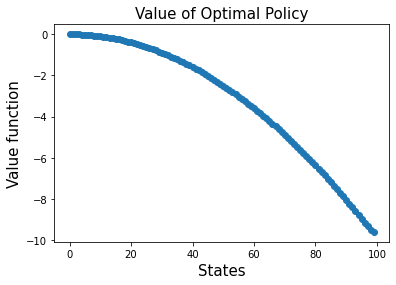

In [57]:
# Policy Iteration
Value_policy,_=policy_iteration(gamma,np.zeros(N),100)
plt.scatter(list(range(100)),Value_policy)
plt.xlabel('States', fontsize='15')
plt.ylabel('Value function',fontsize='15')
plt.title('Value of Optimal Policy',fontsize='15')


In [58]:
# Defining the q function
def q_function(values,gamma):
    optimal_policy = np.array(['lazy']*N)

    for x in range(N):
        values_list = np.zeros(2)
        for q,m,n,pi in zip([q_low,q_high],[m_low,m_high],[0,1],['lazy','aggressive']):
            values[n] = reward(q,x) + 0.5*gamma*m[x,:].dot(values)
        
        max_list = []
        max_value = np.max(values_list)
        for n,policy in zip([0,1],['lazy','aggressive']):
            if values_list[n] == max_value:
                max_list.append(policy)
        optimal_policy[x] = np.random.choice(list(max_list))

    return optimal_policy

In [59]:

translated_policy = translate_policy(opti_pol)

In [38]:
#values_1 = LSTD(max_iter=10000,N=100,initial_state=99,maps='piece',gamma=0.9,policy='optimal',policy_vector=translated_policy,m_low=m_low,m_high=m_high,q_high=q_high,q_low=q_low)


In [65]:
results = {'map':[],'policy':[],'iter':[],'value':[], 'policy_action':[]}

for mapping in ['fine','coarse','piece']:
    for pol in ['lazy','aggressive']:
        values = LSTD(max_iter=10000,N=100,initial_state=99,maps=mapping,gamma=0.9,policy=pol,policy_vector = None, m_low=m_low,m_high=m_high,q_high=q_high,q_low=q_low)
        for i in tqdm(range(N)):
            policy_values = q_function(values,gamma)
            values = LSTD(max_iter=10000,N=100,initial_state=99,maps=mapping,gamma=0.9,policy='optimal',policy_vector=translated_policy,m_low=m_low,m_high=m_high,q_high=q_high,q_low=q_low)
            if i in [9, 99]:
                results['map'].append(mapping)
                results['policy'].append(pol)
                results['iter'].append(str(i+1))
                results['value'].append(values.copy())
                results['policy_action'].append(policy_values.copy())
            

100%|██████████| 100/100 [04:19<00:00,  2.60s/it]


In [66]:
results_df = pd.DataFrame(results)
results_value = results_df.explode('value').reset_index()
results_value['state'] = np.tile(range(100), int(len(results_value)/len(range(100))))
results_value.drop(['index','policy_action'] ,axis=1,  inplace=True)

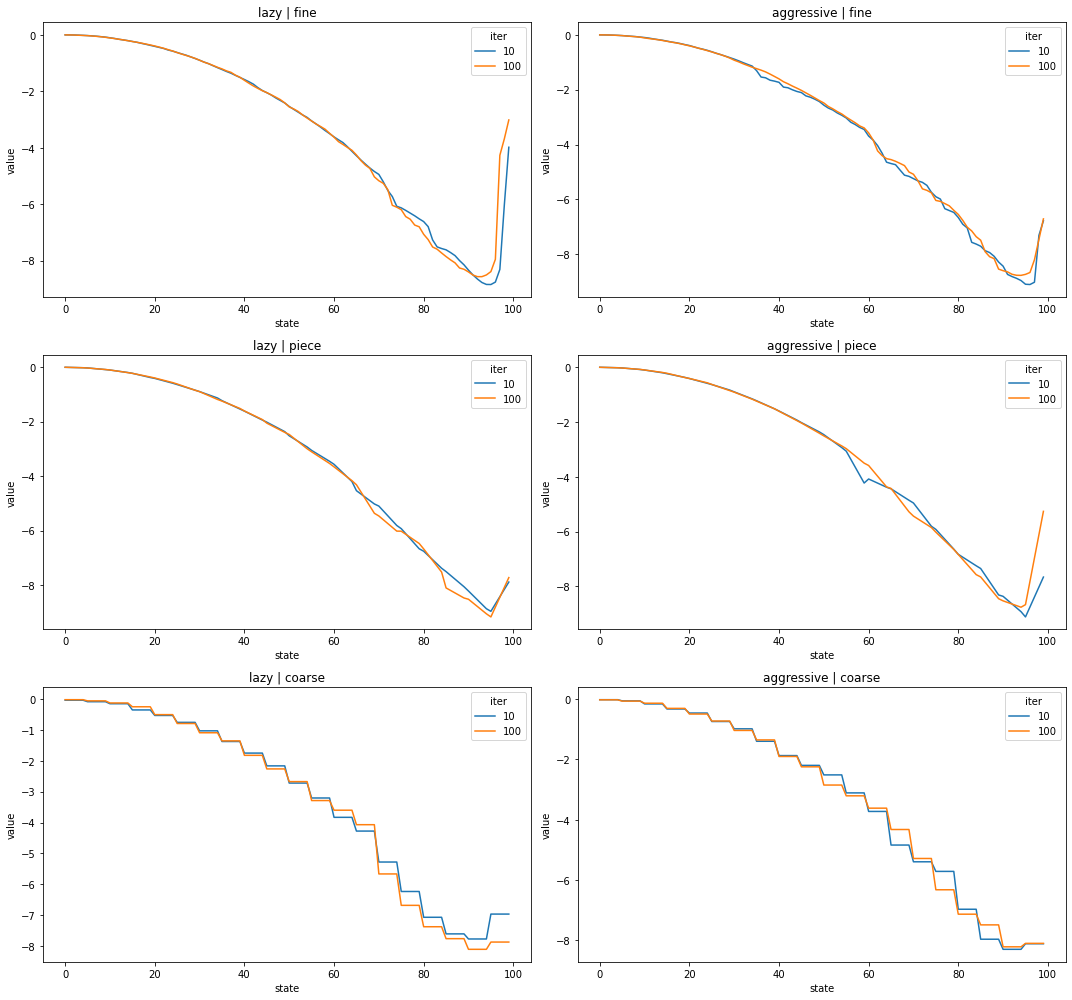

In [67]:
policies = ['lazy', 'aggressive']
methods = ['td0','lstd0']
f_maps = ['fine','piece','coarse']

fig, ax = plt.subplots(len(f_maps), 2, figsize=(15,14))
for p in range(len(policies)):
    for f in range(len(f_maps)):
        label = f'{policies[p]} | {f_maps[f]}'
        ax[f,p].set_title(label = label)
        data = results_value[(results_value.policy==policies[p]) & (results_value.map==f_maps[f])]
        g = sns.lineplot(data = data, x='state',y='value', hue='iter', ax=ax[f,p])

plt.tight_layout()

The graphs above show the values of the lazy and the aggressive policies under the three feature maps for 10 and 100 iterations. The main difference is that in this problem, we include the policy improvement method (q-function) that tries to find an approximation of an optimal policy. We can see that for all feature maps the convergence in both sets of iterations (10 and 100) improves significantly compared to the results in Problem 1. Furthermore, one could argue that the performance when using the fine or piecewise feature maps is better than when we use coarse.

In [68]:
results_policies = pd.DataFrame(results)
results_policies.drop(['value'], axis=1, inplace=True)
results_policies

,map,policy,iter,policy_action
0,fine,lazy,10,"[lazy, lazy, aggr, lazy, lazy, aggr, lazy, laz..."
1,fine,lazy,100,"[lazy, lazy, lazy, lazy, aggr, aggr, aggr, agg..."
2,fine,aggressive,10,"[lazy, lazy, aggr, lazy, lazy, aggr, aggr, laz..."
3,fine,aggressive,100,"[aggr, lazy, lazy, aggr, lazy, aggr, lazy, agg..."
4,coarse,lazy,10,"[lazy, aggr, aggr, lazy, lazy, lazy, aggr, agg..."
5,coarse,lazy,100,"[aggr, lazy, lazy, aggr, aggr, aggr, lazy, agg..."
6,coarse,aggressive,10,"[lazy, lazy, lazy, lazy, lazy, lazy, lazy, agg..."
7,coarse,aggressive,100,"[lazy, aggr, lazy, aggr, lazy, lazy, aggr, laz..."
8,piece,lazy,10,"[lazy, aggr, lazy, lazy, lazy, lazy, lazy, laz..."
9,piece,lazy,100,"[lazy, aggr, aggr, aggr, lazy, lazy, lazy, agg..."
